In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

from nltk.corpus import stopwords

from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

2025-05-10 20:55:11.928189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746910512.144826      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746910512.210983      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
from datasets import load_dataset

# Завантаження датасету
dataset = load_dataset('mavinsao/reddit-mental-illness-82')
df_tr = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_ts = dataset['test'].to_pandas()
df = pd.concat([df_tr, df_val, df_ts], axis=0, ignore_index=True)

# Перетворення тексту на нижній регістр
df['text'] = df['text'].str.lower()

# Фільтрація рядків за наявністю ключових слів
keywords = [
    "think i have", "i think i have", "i think it might be", "i think i could have",
    "might have", "i might have", "might be", "feel like i have", "i feel like i have",
    "feels like i have", "self-diagnose", "self-diagnosed", "i've self-diagnosed",
    "unsure if i have", "i'm unsure if", "unsure if this is", "wonder if i have",
    "i wonder if i have", "wonder if it's", "symptoms of", "i have symptoms of",
    "experiencing symptoms of", "suspect i have", "i suspect i have", "i suspect it's",
    "probably have", "i probably have", "i think i probably have", "could be", "it could be",
    "seems like i have", "it seems like i have", "it seems like", "not diagnosed but",
    "i am not diagnosed but", "i haven't been diagnosed but"
]

df = df[~df['text'].str.contains('|'.join(keywords), case=False, na=False)]

# Розбиття тексту на заголовок і основний текст
def split_text(row):
    if ':' in row:
        parts = row.split(':', 1)
        return parts[0].strip(), parts[1].strip()
    return None, row.strip()

df[['title', 'main_text']] = df['text'].apply(split_text).apply(pd.Series)

# Перевірка результату
print(df[['title', 'main_text', 'label']])


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

                                                   title  \
0                              fantasizing about your fp   
1      this is a support subreddit for people with a ...   
2                        scared of my psychotic symptoms   
4      i feel like a sick animal that needs to be put...   
5      is constantly checking ocd subreddits a compul...   
...                                                  ...   
52637  i got diagnosed with pure o, and finding it di...   
52638                 where can i read up on propaganda?   
52639  need help "keeping thoughts straight," or, mai...   
52640  does anyone else feel like none of their exper...   
52641                         wish me luck at work today   

                                               main_text  label  
0      do you do it? what do you fantasize about? : w...      3  
1      it's not for posting how infuriating the uneve...      6  
2      i'm trying to keep reminding myself that what ...      2  
4      i had a 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import spacy

# Функція очищення тексту
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'<.*?>+', '', regex=True)
    text = text.str.replace(r'\w*\d\w*', '', regex=True)
    return text

# Функція видалення стоп-слів
# custom_stopwords = {'ocd', 'anxiety', 'adhd', 'ptsd', 'bpd', 'depression', 'bipolar'}
custom_stopwords = {}
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(custom_stopwords)
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in stop_words))
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

# Застосування функцій до обох стовпців
def process_text_columns(df, columns):
    for col in columns:
        # Очищення тексту
        df[col] = clean_text(df[col])
        # Видалення стоп-слів
        df[col] = remove_stopwords(df[col])
        # Видалення найчастіших слів
        delete = pd.Series(' '.join(df[col]).split()).value_counts()[-1000:]
        df[col] = df[col].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in delete))
        # Лематизація
        df[col] = df[col].apply(lemmatize_sentence)
    return df


df = pd.DataFrame(df)
df = process_text_columns(df, ['title', 'main_text'])

print(df)


                                                    text  label  \
0      fantasizing about your fp: do you do it? what ...      3   
1      this is a support subreddit for people with a ...      6   
2      scared of my psychotic symptoms : i'm trying t...      2   
4      i feel like a sick animal that needs to be put...      4   
5      is constantly checking ocd subreddits a compul...      6   
...                                                  ...    ...   
52637  i got diagnosed with pure o, and finding it di...      6   
52638  where can i read up on propaganda? : i want to...      5   
52639  need help "keeping thoughts straight," or, mai...      0   
52640  does anyone else feel like none of their exper...      1   
52641  wish me luck at work today : oh god my anxiety...      1   

                                                   title  \
0                                           fantasize fp   
1                support subreddit people mental illness   
2              

In [6]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.5 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


   

#  основний текст 
# df['text'] = df['title'].str.strip(':') + ' ' + df['main_text']
df['text'] = df['main_text']
# Розподіл на X (тексти) та y (мітки)
X = df['text']
y = df['label']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Застосування undersampling
X_res, y_res = undersampler.fit_resample(X.values.reshape(-1, 1), y)
print("Розподіл класів після балансування:")
print(pd.Series(y_res).value_counts())
balanced_df = pd.DataFrame({
    'text': X_res.flatten(),
    'label': y_res
})

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

print("\nРозподіл класів у тренувальному наборі:")
print(train_df['label'].value_counts())
print("\nРозподіл класів у тестовому наборі:")
print(test_df['label'].value_counts())


Розподіл класів після балансування:
label
0    4086
1    4086
2    4086
3    4086
4    4086
5    4086
6    4086
7    4086
Name: count, dtype: int64

Розподіл класів у тренувальному наборі:
label
5    3335
0    3296
1    3279
4    3264
6    3264
3    3260
2    3228
7    3224
Name: count, dtype: int64

Розподіл класів у тестовому наборі:
label
7    862
2    858
3    826
6    822
4    822
1    807
0    790
5    751
Name: count, dtype: int64



Логістична регресія

Test Set Evaluation:
Accuracy: 0.7416641174671154

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       790
           1       0.72      0.69      0.70       807
           2       0.74      0.64      0.69       858
           3       0.69      0.65      0.67       826
           4       0.59      0.73      0.65       822
           5       0.82      0.97      0.89       751
           6       0.86      0.75      0.80       822
           7       0.80      0.75      0.77       862

    accuracy                           0.74      6538
   macro avg       0.75      0.74      0.74      6538
weighted avg       0.75      0.74      0.74      6538


Confusion Matrix:
[[609  26  35  31  41  29  11   8]
 [ 39 557  21  39  67  17  33  34]
 [ 46  35 552  36 109  35  10  35]
 [ 27  35  48 540 101  17  20  38]
 [ 28  30  39  65 598  23   4  35]
 [ 10   2   1   1   3 731   2   1]
 [ 24  44  20  30  45  26 619  14]
 [ 20  45  

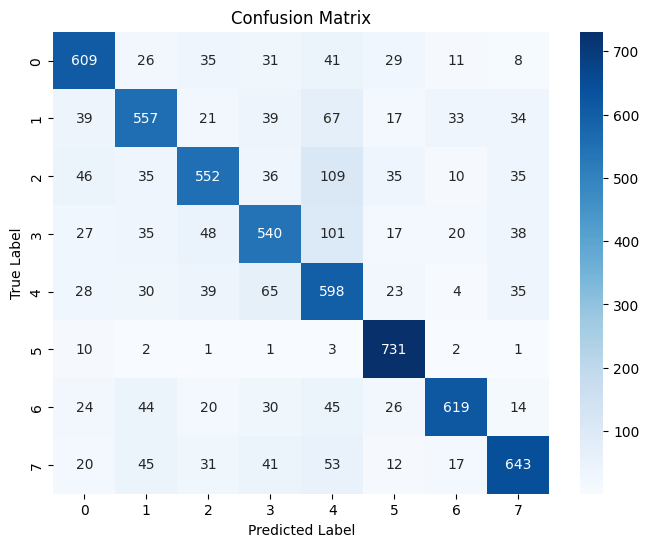

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Логістична регресія
logistic_regression_classifier = LogisticRegression(max_iter=100, random_state=892)
logistic_regression_classifier.fit(X_train, y_train)

y_test_pred = logistic_regression_classifier.predict(X_test)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

print("\nClassification Report:")
class_names = label_encoder.classes_.astype(str)
print(classification_report(y_test, y_test_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.698690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269994
[LightGBM] [Info] Number of data points in the train set: 26150, number of used features: 4847
[LightGBM] [Info] Start training from score -2.071140
[LightGBM] [Info] Start training from score -2.076311
[LightGBM] [Info] Start training from score -2.091986
[LightGBM] [Info] Start training from score -2.082122
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.059377
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.093226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

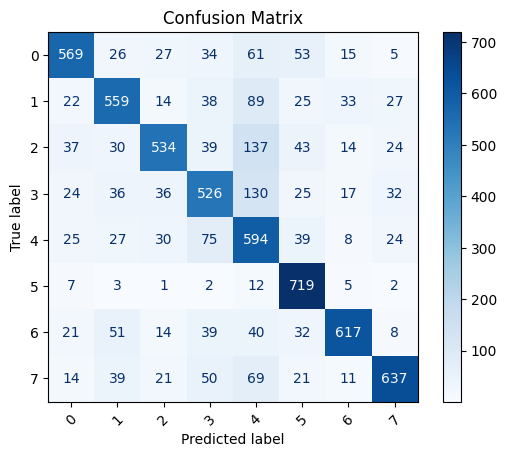

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# LightGBM
lgbm_classifier = LGBMClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
lgbm_classifier.fit(X_train, y_train)
y_test_pred = lgbm_classifier.predict(X_test)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


BiLSTM


Using device: cuda
Epoch 1/10, Loss: 1.6469, Accuracy: 0.3550
Epoch 2/10, Loss: 0.9633, Accuracy: 0.6707
Epoch 3/10, Loss: 0.7782, Accuracy: 0.7400
Epoch 4/10, Loss: 0.6529, Accuracy: 0.7834
Epoch 5/10, Loss: 0.5352, Accuracy: 0.8283
Epoch 6/10, Loss: 0.4225, Accuracy: 0.8658
Epoch 7/10, Loss: 0.3115, Accuracy: 0.9047
Epoch 8/10, Loss: 0.2260, Accuracy: 0.9317
Epoch 9/10, Loss: 0.1596, Accuracy: 0.9515
Epoch 10/10, Loss: 0.1175, Accuracy: 0.9659
Test Loss: 1.4461, Test Accuracy: 0.6936


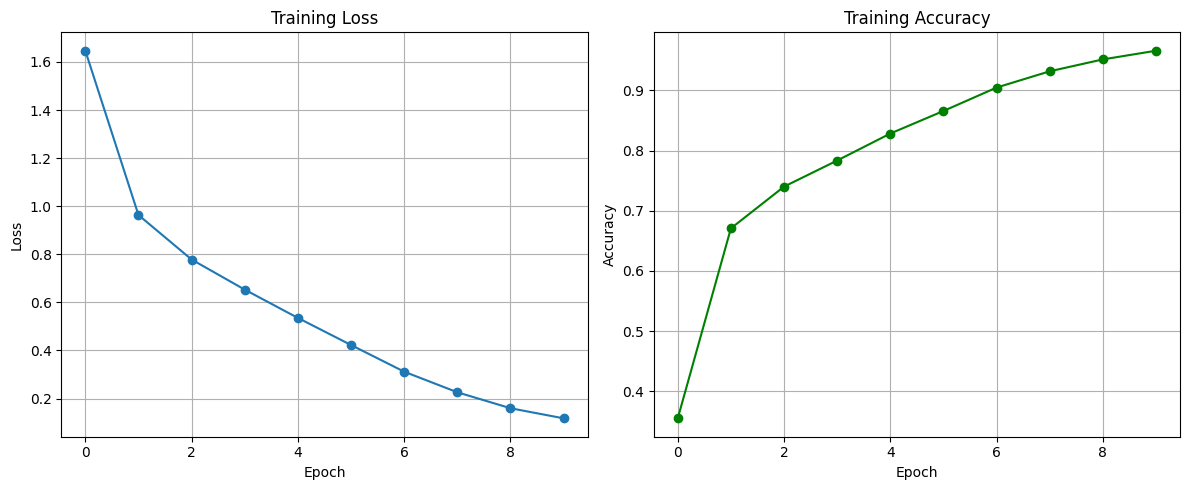

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# === Підготовка даних ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

max_len = max(len(x) for x in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# === Архітектура моделі ===
class AttentionLayer(nn.Module):
    def __init__(self, lstm_units):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(lstm_units * 2, 1)

    def forward(self, x):
        scores = self.attention(x)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(weights * x, dim=1)
        return context

class ThreeLayerLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, output_dim, dropout_rate):
        super(ThreeLayerLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, lstm_units, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.lstm2 = nn.LSTM(lstm_units * 2, lstm_units, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.lstm3 = nn.LSTM(lstm_units * 2, lstm_units, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.attention = AttentionLayer(lstm_units)
        self.fc = nn.Linear(lstm_units * 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.attention(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# === Гіперпараметри ===
embed_dim = 100
lstm_units = 128
dropout_rate = 0.3
learning_rate = 1e-3
output_dim = len(np.unique(y_train))

model = ThreeLayerLSTMWithAttention(
    vocab_size=len(tokenizer.word_index) + 1,
    embed_dim=embed_dim,
    lstm_units=lstm_units,
    output_dim=output_dim,
    dropout_rate=dropout_rate
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# === Тренування ===
def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    history = {"loss": [], "accuracy": []}
    
    for epoch in range(epochs):
        total_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / len(train_loader.dataset)
        history["loss"].append(avg_loss)
        history["accuracy"].append(accuracy)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return history

# === Оцінка ===
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1).cpu().numpy()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}")
    return accuracy

# === Запуск тренування та побудова графіка ===
history = train_model(model, train_loader, optimizer, criterion, device, epochs=10)
evaluate_model(model, test_loader, device)

# === Побудова графіків ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["loss"], marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()


Test Accuracy: 0.6936

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       790
           1       0.57      0.72      0.64       807
           2       0.67      0.62      0.64       858
           3       0.61      0.62      0.61       826
           4       0.56      0.57      0.57       822
           5       0.88      0.91      0.89       751
           6       0.82      0.72      0.76       822
           7       0.75      0.71      0.73       862

    accuracy                           0.69      6538
   macro avg       0.70      0.70      0.70      6538
weighted avg       0.70      0.69      0.69      6538



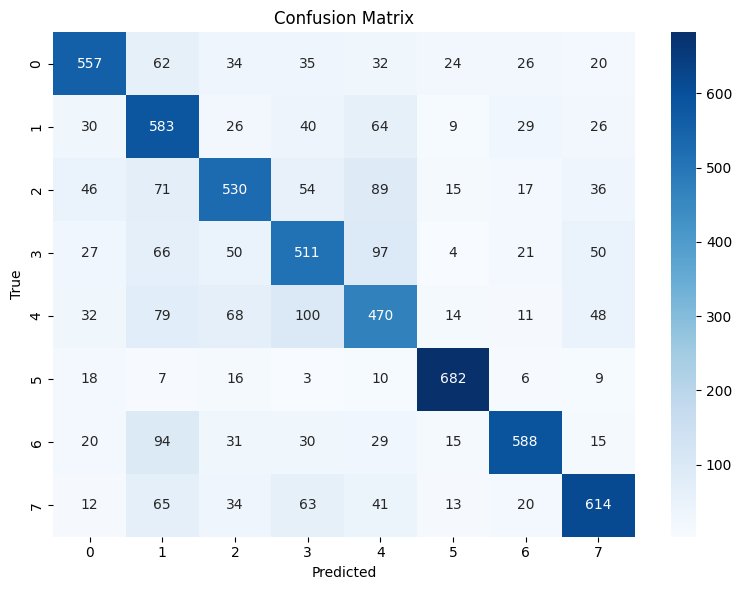

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_with_report(model, test_loader, device, label_encoder):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Точність
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names = [str(cls) for cls in label_encoder.classes_]
))


    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
evaluate_model_with_report(model, test_loader, device, label_encoder)
